# LSTM Time Series Forecasting

Sources:
* [TensorFlow documentation - Time series forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series)
* [Multivariate Time Series Forecasting with LSTMs in Keras](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)
* [How to Convert a Time Series to a Supervised Learning Problem in Python](https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/)
* [Coursera Sequences, Time Series and Prediction by deeplearning.ai](https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction)

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from google.cloud import bigquery
import tensorflow as tf
print(tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'), '(for more info run nvidia-smi from terminal)')

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from math import sqrt

# Print all outputs in a code block
from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"
#InteractiveShell.ast_node_interactivity = 'none'

seed_global = 42

2.3.0
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] (for more info run nvidia-smi from terminal)


In [2]:
def plot_series(time, series, label=None, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format, label=label);
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)

In [3]:
from datetime import datetime
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

df = pd.read_csv('https://raw.githubusercontent.com/soltaniehha/Intro-to-Data-Analytics/main/data/pollution.csv',
                 parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)

df.drop('No', axis=1, inplace=True)
# manually specify column names
df.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
df.index.name = 'date'
# mark all NA values with 0
df['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
df = df[24:]
# first few rows
df.head(3)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0


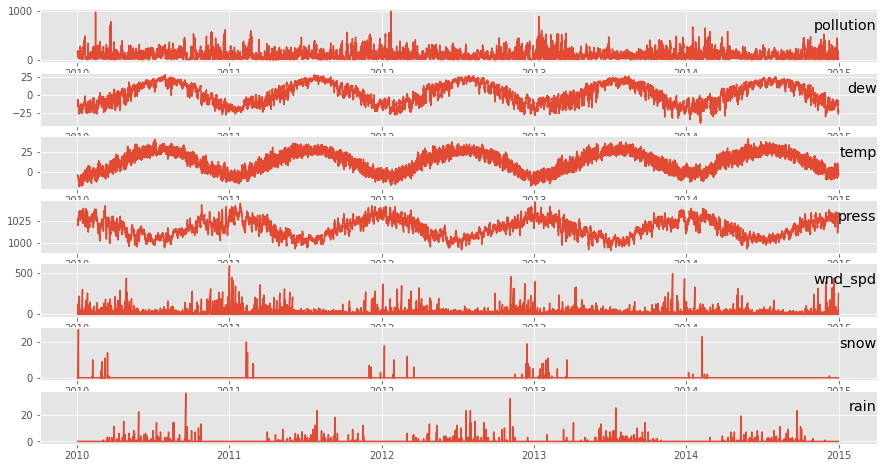

In [4]:
values = df.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
fig = plt.figure(figsize=(15,8));
for group in groups:
    plt.subplot(len(groups), 1, i);
    plt.plot(df.index, values[:, group]);
    plt.title(df.columns[group], y=0.5, loc='right');
    i += 1;

### Integer encode direction

In [5]:
encoder = LabelEncoder()
df['wnd_dir'] = encoder.fit_transform(df['wnd_dir'])
# ensure all data is float
df = df.astype('float32')
df.head(3)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16.0,-4.0,1020.0,2.0,1.79,0.0,0.0
2010-01-02 01:00:00,148.0,-15.0,-4.0,1020.0,2.0,2.68,0.0,0.0
2010-01-02 02:00:00,159.0,-11.0,-5.0,1021.0,2.0,3.57,0.0,0.0


## TRAIN_SPLIT boundry

In [6]:
TRAIN_SPLIT = 365 * 24

### Standardize the dataset

In [7]:
df_stand = df.copy()
dataset = df_stand.values

scaler = StandardScaler()
scaler.fit(dataset[:TRAIN_SPLIT])
df_stand[df_stand.columns] = scaler.transform(dataset)

df_stand.head(3)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,0.354194,-1.221707,-1.238937,0.373207,0.417329,-0.476918,-0.072693,-0.148257
2010-01-02 01:00:00,0.558743,-1.152258,-1.238937,0.373207,0.417329,-0.461181,-0.072693,-0.148257
2010-01-02 02:00:00,0.677165,-0.874462,-1.318190,0.476263,0.417329,-0.445445,-0.072693,-0.148257


In [8]:
# This cell is not a part of the pipeline. Just to check the lags:
def df_to_supervized(dataset, target_var, n_lags=1):
    """
    dataset: DataFrame including the target variable. (required)
    target_var: the target variable. (required)
    n_lags: number of lags to be produced
    """
    cols, names = list(), list()
    for i in range(n_lags, 0, -1):
        cols.append(dataset.shift(i))
        names += [(str(j) + '(t-%d)' % (i)) for j in dataset.columns]
    # target variable
    cols.append(dataset[[target_var]])
    names += [target_var]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg

# frame for supervized learning
series = df_to_supervized(df_stand, 'pollution', n_lags=1)

series.head(3)

,pollution(t-1),dew(t-1),temp(t-1),press(t-1),wnd_dir(t-1),wnd_spd(t-1),snow(t-1),rain(t-1),pollution
date,,,,,,,,,
2010-01-02 01:00:00,0.354194,-1.221707,-1.238937,0.373207,0.417329,-0.476918,-0.072693,-0.148257,0.558743
2010-01-02 02:00:00,0.558743,-1.152258,-1.238937,0.373207,0.417329,-0.461181,-0.072693,-0.148257,0.677165
2010-01-02 03:00:00,0.677165,-0.874462,-1.318190,0.476263,0.417329,-0.445445,-0.072693,-0.148257,0.914011


## Ploting functions

In [9]:
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                     label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
             label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

## Split Multivariate TS to train/validation

In [10]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    """
    dataset: a 2D array that includes all of X and y variables
    target: y variable
    start_index: starting index of train or validation
    end_index: last index of train or validation
    history_size: how far back the lag should go
    target_size: How many steps ahead we want to predict?
        target_size=0 is equivalent to now-casting
    step: time steps between data points used. 1 is the natural value. 
        For high frequency data this can be set to higher values
    single_step: 
        single_step=True will predict one value in the future.
        single_step=False will predict multiple
    """
    data = []
    labels = []

    start_index = start_index if start_index >= history_size else start_index + history_size
    end_index = len(dataset) - target_size if end_index is None else end_index

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

past_history = 72
future_target = 0  # How many steps ahead to forecast
STEP = 1

x_train, y_train = multivariate_data(dataset=df_stand.values, 
                                             target=df_stand['pollution'].values, 
                                             start_index=0, 
                                             end_index=TRAIN_SPLIT, 
                                             history_size=past_history,
                                             target_size=future_target, 
                                             step=STEP,
                                             single_step=True)

x_val, y_val = multivariate_data(dataset=df_stand.values, 
                                         target=df_stand['pollution'].values,
                                         start_index=TRAIN_SPLIT, 
                                         end_index=None, 
                                         history_size=past_history,
                                         target_size=future_target, 
                                         step=STEP,
                                         single_step=True)

time_train = df_stand.index[TRAIN_SPLIT-y_train.shape[0]:TRAIN_SPLIT]
time_valid = df_stand.index[TRAIN_SPLIT:]

print("\nShape of x_train:", x_train.shape)
print("\nShape of x_val:", x_val.shape)
#print('\nAn exmaple training point (t =', time_train[1], '):', x_train[0])
#print('\n...and its corresponding label:', y_train[0])


Shape of x_train: (8688, 72, 8)

Shape of x_val: (35040, 72, 8)


In [11]:
BATCH_SIZE = 72
BUFFER_SIZE = 5000

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(BATCH_SIZE)

## Fit the model

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

EPOCHS = 20
EVALUATION_INTERVAL = 100  # steps_per_epoch (number of weight updates)

# design network
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, 
                         input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-2)

model.compile(loss='mae', 
              optimizer=optimizer, 
              metrics=['mse'])

history = model.fit(train_data, 
                    epochs=EPOCHS,
                    steps_per_epoch=EVALUATION_INTERVAL,
                    validation_data=val_data,
                    validation_steps=50)

Epoch 1/20
100/100 [==============================] - 1s 12ms/step - loss: 0.2309 - mse: 0.1734 - val_loss: 0.1544 - val_mse: 0.0875
Epoch 2/20
100/100 [==============================] - 1s 7ms/step - loss: 0.1624 - mse: 0.0991 - val_loss: 0.1599 - val_mse: 0.0881
Epoch 3/20
100/100 [==============================] - 1s 7ms/step - loss: 0.1583 - mse: 0.0903 - val_loss: 0.1533 - val_mse: 0.0754
Epoch 4/20
100/100 [==============================] - 1s 7ms/step - loss: 0.1616 - mse: 0.0828 - val_loss: 0.1463 - val_mse: 0.0767
Epoch 5/20
100/100 [==============================] - 1s 7ms/step - loss: 0.1637 - mse: 0.1051 - val_loss: 0.1490 - val_mse: 0.0785
Epoch 6/20
100/100 [==============================] - 1s 7ms/step - loss: 0.1573 - mse: 0.0965 - val_loss: 0.1423 - val_mse: 0.0781
Epoch 7/20
100/100 [==============================] - 1s 7ms/step - loss: 0.1541 - mse: 0.0926 - val_loss: 0.1468 - val_mse: 0.0768
Epoch 8/20
100/100 [==============================] - 1s 7ms/step - loss: 0

Let's check out a sample prediction.

In [13]:
for x, y in val_data.take(1):
    print(model.predict(x).shape)

(72, 1)


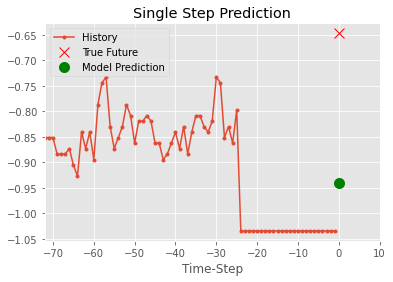

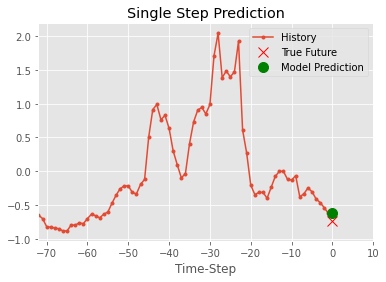

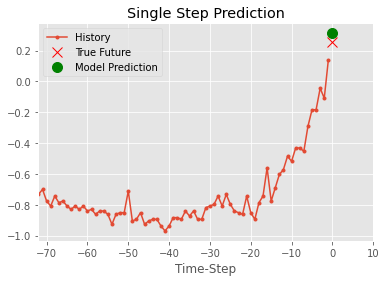

In [14]:
for x, y in val_data.take(3):
    plot = show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                      model.predict(x)[0]], 0,
                     'Single Step Prediction')
    plot.show()

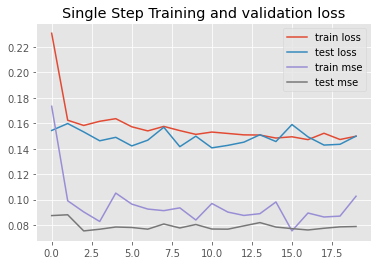

In [15]:
# Plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.plot(history.history['mse'], label='train mse')
plt.plot(history.history['val_mse'], label='test mse')
plt.title('Single Step Training and validation loss')
plt.legend()
plt.show();

In [16]:
# make prediction
yhat = model.predict(val_data)

# invert scaling for forecast
L = y_val.shape[0]
inv_y_val = scaler.inverse_transform(np.append(y_val.reshape((L, 1)), np.zeros([L, dataset.shape[1]-1]), axis=1))[:,0]
inv_yhat_val = scaler.inverse_transform(np.append(yhat.reshape((L, 1)), np.zeros([L, dataset.shape[1]-1]), axis=1))[:,0]

y_pred = pd.DataFrame({'y_val':inv_y_val,
                       'yhat_val':inv_yhat_val},
                      index=time_valid)

# calculate RMSE
rmse = sqrt(tf.keras.metrics.mean_squared_error(inv_y_val, inv_yhat_val))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 27.591


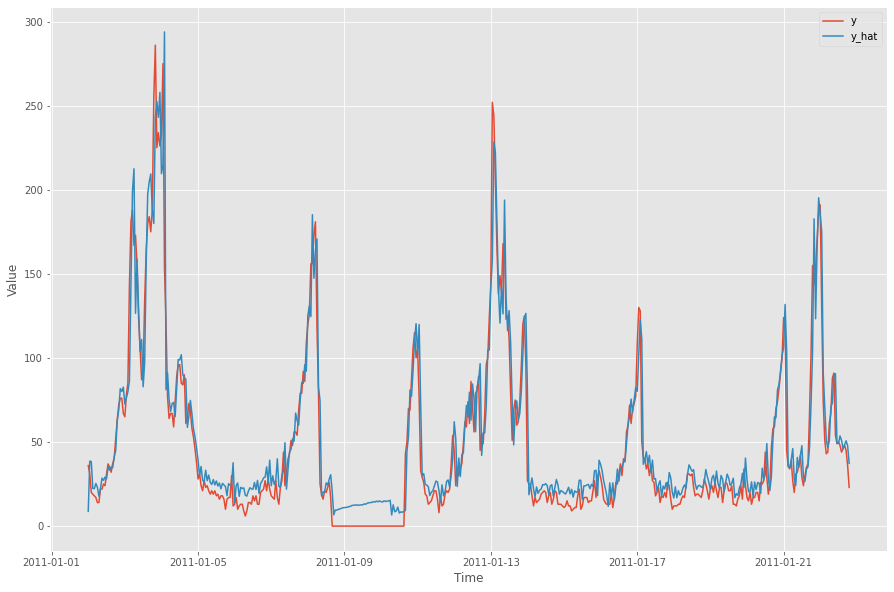

In [17]:
plt.figure(figsize=(15, 10))
plot_series(y_pred.index, y_pred['y_val'], label='y', end=500)
plot_series(y_pred.index, y_pred['yhat_val'], label='y_hat', end=500)